# Price Prediction

In [1]:
__author__ = "Jiting Jiang"
__email__ = "jiting.jiang@outlook.com"
__website__ = "https://jitingjiang.github.io/minimal-portfolio/"

## Goals

In this project,I will do the following. 
1. [import, clean and explore the dataset](#1)
2. [predict price using linear regression with gradient descent (sklearn)](#2)
3. [predict price using ordinary least squares (sklearn/statsmodel)](#3)
4. [compare the estimates and predictions between the three models](#4)
5. [explore the impact of feature scaling on gradient descent](#5)

Plus [run gradient descent manually and visualize the impact of learing rate on gradient descent](#bonus)

## Tools

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [4]:
import statsmodels.api as sm
import math

In [5]:
import copy

## 1 - Import, Clean, and Explore Dataset <a name="1"></a>

### 1.0 - Import data

The raw dataset includes 10,000 records and 8 features, with 7 of them having generic feature names. Features starting with 'para' are in numeric data types, while the rest features are in object data types. The feature 'dow' likely shows the day of the week, based on its name. The target outcome is 'price'.

In [6]:
price_raw = pd.read_csv('sample.csv')
price_raw

,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,01,1,Mon,662,3000.0,3.8,73.49
1,9,99,1,Thu,340,2760.0,9.2,300.00
2,0,04,0,Mon,16,2700.0,3.0,130.00
3,4,40,1,Mon,17,12320.0,6.4,365.00
4,5,50,1,Thu,610,2117.0,10.8,357.50
...,...,...,...,...,...,...,...,...
9995,9,98,3,Fri,386,5000.0,12.0,460.00
9996,7,74,1,Thu,386,3250.0,8.0,325.00
9997,0,06,0,Tue,190,8856.0,5.6,133.33
9998,7,74,3,Fri,717,5000.0,13.6,820.00


In [7]:
price_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   loc1    10000 non-null  object 
 1   loc2    10000 non-null  object 
 2   para1   10000 non-null  int64  
 3   dow     10000 non-null  object 
 4   para2   10000 non-null  int64  
 5   para3   10000 non-null  float64
 6   para4   10000 non-null  float64
 7   price   10000 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 625.1+ KB


### 1.1 - Clean and explore data

In this subsection, I perform common steps for Exploratory Data Analysis (EDA) to prepare the data for further analysis and modeling. Here is a breakdown of the steps involved:

* <ins>Data Type Revision</ins>: I review the data types in the dataset and make necessary transformations, such as converting 'object' variables to 'numeric' types. I also perform one-hot encoding on categorical features to create dummy variables. 

* <ins>Feature Description</ins>: I provide descriptive statistics for both numerical and categorical features in the dataset.

* <ins>Missing Values Check</ins>: I examine the dataset for any missing values and address them if necessary through imputation or other suitable methods.

* <ins>Univariate and Bivariate Relationships</ins>: I explore the variables through univariate analysis, examining their distributions, central tendencies, and variability. I also run bivariate analysis to shed insights on potential correlations. In particular, I use 'pariplot' for visualization.

* <ins>Outlier Address</ins>: I identify any obvious outliers in the dataset by examining the descriptive statistics and visualizations and remove them if proper. 

* <ins>Feature Selection</ins>: I select the three most relevant features for the target 'price' based on correlation coefficients.

* <ins>Feature Scaling</ins>: In addition to the unscaled features, i also apply the Z-score scaling method to the dataset. This allows for a comparison between the unscaled and scaled versions, assessing the impact of feature scaling on gradient descent. 

#### 1.1.1 - Describe numerical and categorical features

In [8]:
# Describe numerical features
price_raw.describe()

,para1,para2,para3,para4,price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.380800,447.384000,9547.989920,8.459522,433.733056
std,3.500831,221.005861,8022.814037,4.613526,277.435947
min,0.000000,16.000000,200.000000,1.000000,50.730000
25%,1.000000,301.000000,2898.000000,4.000000,250.000000
50%,1.000000,434.000000,6447.000000,7.200000,370.000000
75%,1.000000,582.000000,15000.000000,13.600000,550.000000
max,337.000000,2554.000000,34782.000000,27.200000,5700.000000


In [9]:
# Describe categorical features
price_raw.describe(exclude='number')

,loc1,loc2,dow
count,10000,10000,10000
unique,12,107,7
top,2,21,Wed
freq,1607,499,2233


In [10]:
# Tab feature values
for col in price_raw.columns:
    print(price_raw.value_counts(col))

loc1
2    1607
0    1486
1    1223
7    1081
3     945
5     846
4     773
8     727
9     690
6     620
S       1
T       1
dtype: int64
loc2
21    499
06    454
74    329
12    273
14    246
     ... 
0N      1
0L      1
0C      1
0B      1
TS      1
Length: 107, dtype: int64
para1
1      7052
3      1613
0       836
2       268
4       164
5        51
6         6
7         3
9         2
13        2
8         1
24        1
337       1
dtype: int64
dow
Wed    2233
Tue    1997
Fri    1931
Mon    1918
Thu    1908
Sat      10
Sun       3
dtype: int64
para2
16      93
554     73
215     59
509     54
349     52
        ..
962      1
966      1
968      1
971      1
2554     1
Length: 1016, dtype: int64
para3
24000.0    493
5000.0     280
10000.0    272
20000.0    228
15000.0    196
          ... 
4865.0       1
4866.0       1
4870.0       1
4872.0       1
34782.0      1
Length: 4359, dtype: int64
para4
13.60    3306
6.80      437
4.00      426
6.00      350
2.00      278
         ... 
7.9

In [11]:
# Drop records with non-numeric loc1/loc2 values
price_0 = price_raw.copy()

price_0['loc1'] = pd.to_numeric(price_0['loc1'], errors='coerce')
price_0['loc2'] = pd.to_numeric(price_0['loc2'], errors='coerce')
price_0.dropna(inplace=True)

In [12]:
# One-hot encoding for 'dow'
dow_dummies = pd.get_dummies(price_0['dow'], drop_first=True)
dow_dummies

,Mon,Sat,Sun,Thu,Tue,Wed
0,1,0,0,0,0,0
1,0,0,0,1,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
9995,0,0,0,0,0,0
9996,0,0,0,1,0,0
9997,0,0,0,0,1,0
9998,0,0,0,0,0,0


In [13]:
price_1 = pd.concat([price_0, dow_dummies], axis=1)
price_1.drop(['dow'], axis=1, inplace=True)
price_1

,loc1,loc2,para1,para2,para3,para4,price,Mon,Sat,Sun,Thu,Tue,Wed
0,0.0,1.0,1,662,3000.0,3.8,73.49,1,0,0,0,0,0
1,9.0,99.0,1,340,2760.0,9.2,300.00,0,0,0,1,0,0
2,0.0,4.0,0,16,2700.0,3.0,130.00,1,0,0,0,0,0
3,4.0,40.0,1,17,12320.0,6.4,365.00,1,0,0,0,0,0
4,5.0,50.0,1,610,2117.0,10.8,357.50,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9.0,98.0,3,386,5000.0,12.0,460.00,0,0,0,0,0,0
9996,7.0,74.0,1,386,3250.0,8.0,325.00,0,0,0,1,0,0
9997,0.0,6.0,0,190,8856.0,5.6,133.33,0,0,0,0,1,0
9998,7.0,74.0,3,717,5000.0,13.6,820.00,0,0,0,0,0,0


#### 1.1.2 - Check for missing values

In [14]:
# count the number of missing values in each column and sort
missing_values = price_1.isnull().sum().sort_values()
missing_values

loc1     0
loc2     0
para1    0
para2    0
para3    0
para4    0
price    0
Mon      0
Sat      0
Sun      0
Thu      0
Tue      0
Wed      0
dtype: int64

#### 1.1.3 - Check univariate and bivariate relationships

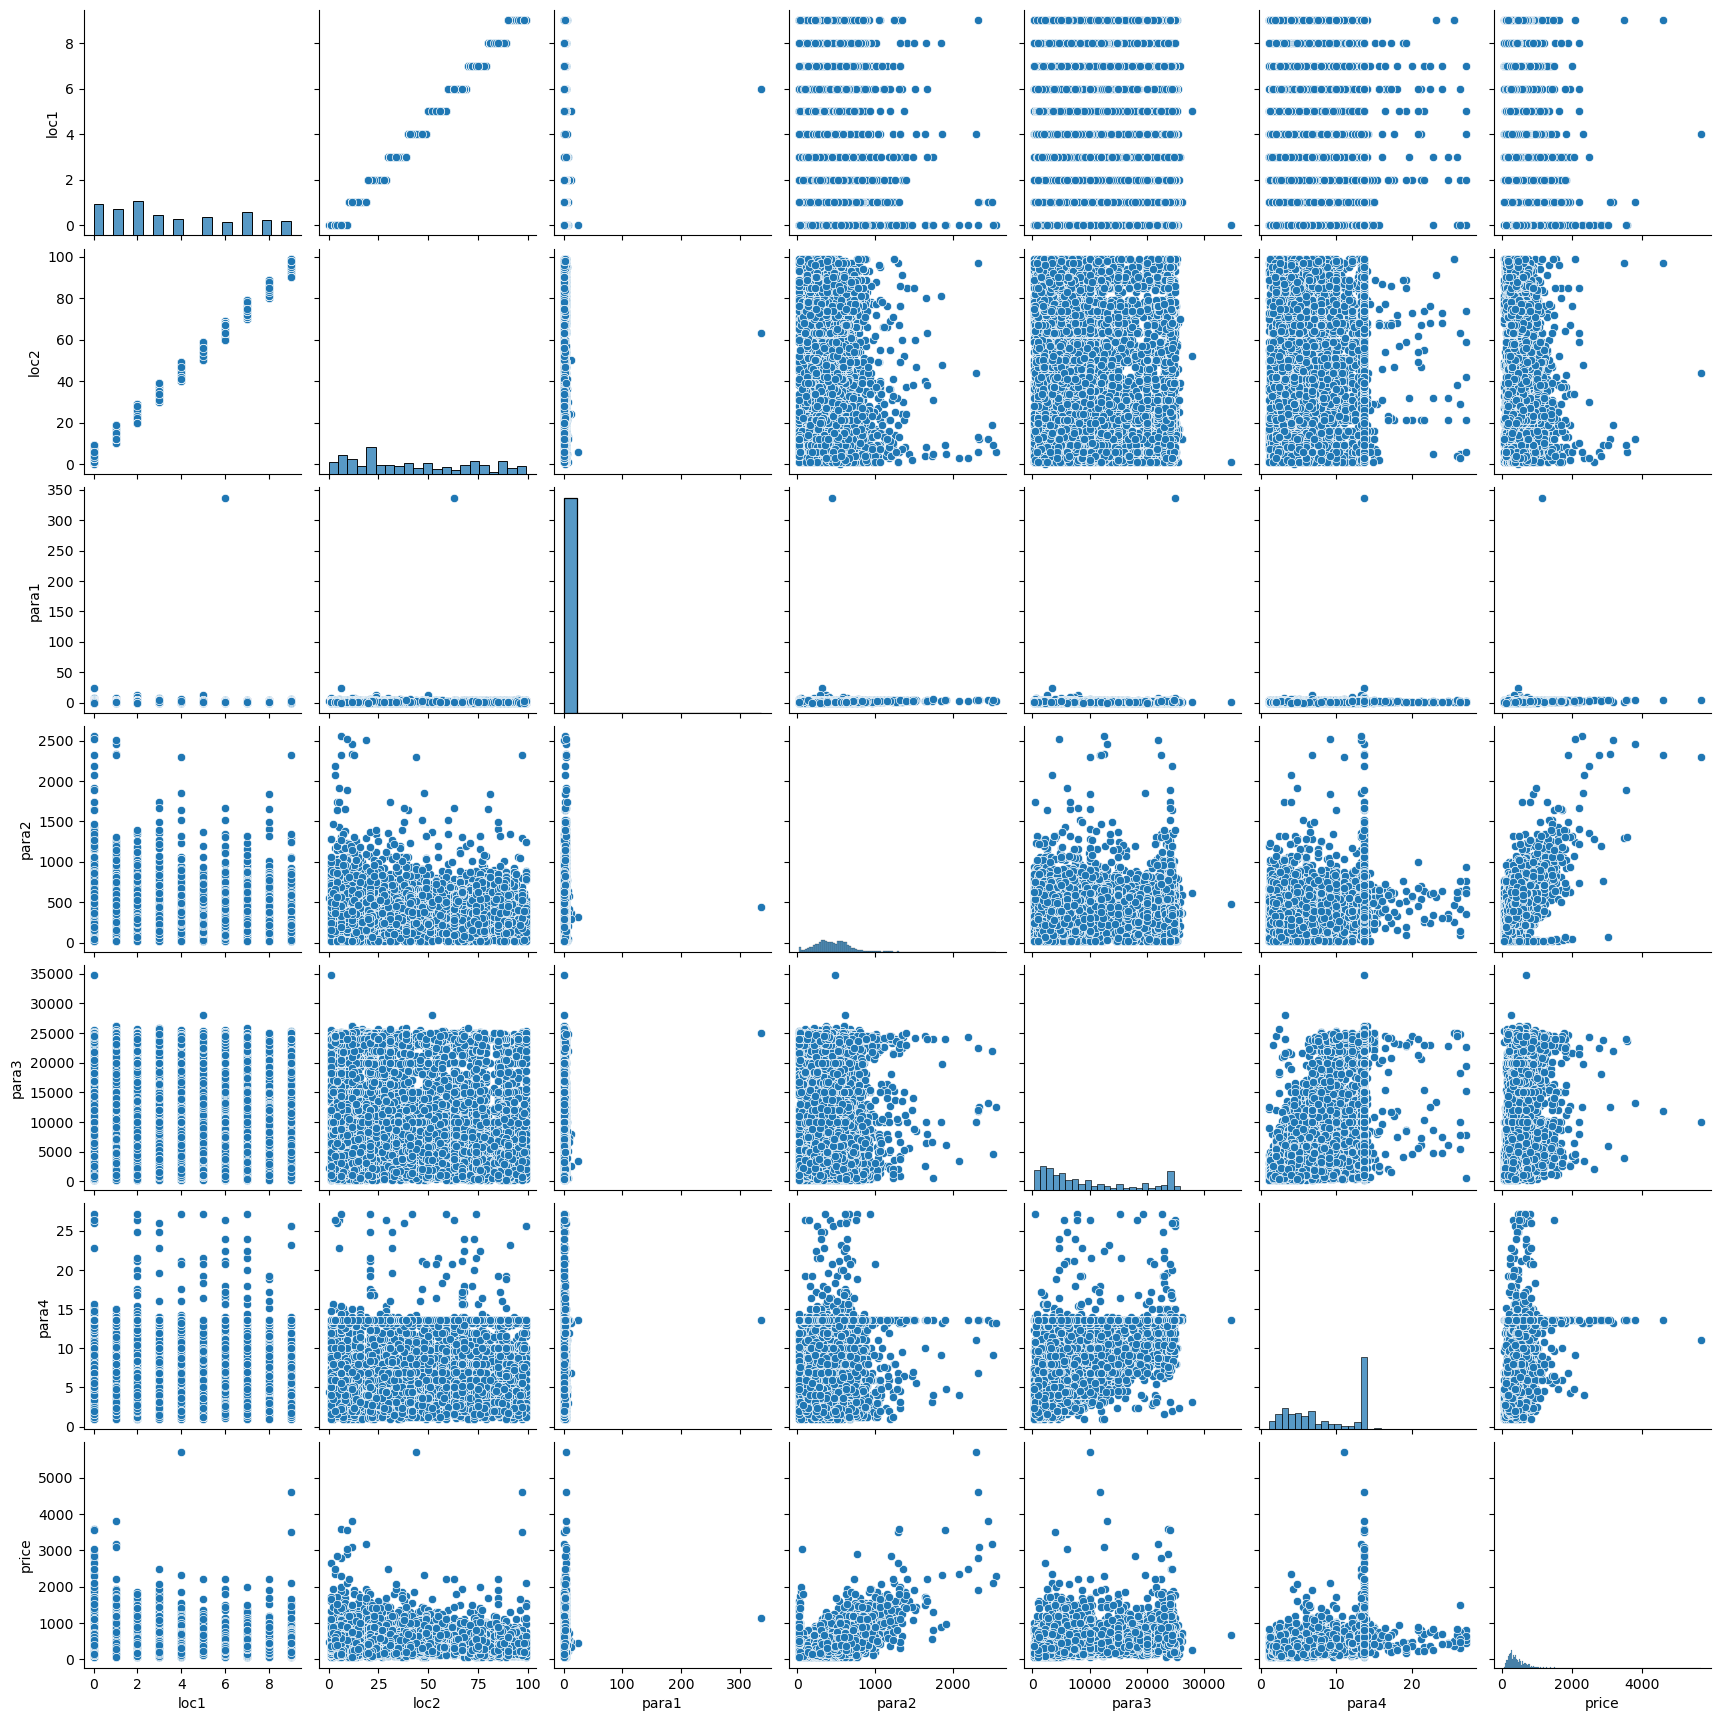

In [15]:
sns.pairplot(price_1.iloc[:,0:7])

In [16]:
# Drop certai values of 'para1'
price_2 = price_1[(price_1['para1']<=10)].reset_index(drop=True)
price_2

,loc1,loc2,para1,para2,para3,para4,price,Mon,Sat,Sun,Thu,Tue,Wed
0,0.0,1.0,1,662,3000.0,3.8,73.49,1,0,0,0,0,0
1,9.0,99.0,1,340,2760.0,9.2,300.00,0,0,0,1,0,0
2,0.0,4.0,0,16,2700.0,3.0,130.00,1,0,0,0,0,0
3,4.0,40.0,1,17,12320.0,6.4,365.00,1,0,0,0,0,0
4,5.0,50.0,1,610,2117.0,10.8,357.50,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,9.0,98.0,3,386,5000.0,12.0,460.00,0,0,0,0,0,0
9985,7.0,74.0,1,386,3250.0,8.0,325.00,0,0,0,1,0,0
9986,0.0,6.0,0,190,8856.0,5.6,133.33,0,0,0,0,1,0
9987,7.0,74.0,3,717,5000.0,13.6,820.00,0,0,0,0,0,0


#### 1.1.4 - Perform Feature Selection and Feature Scaling

In [17]:
pd.DataFrame(abs(price_2.corr()["price"])).sort_values(by = "price", ascending = False)[1:]

,price
para2,0.551435
para4,0.517559
para3,0.356646
para1,0.182487
loc1,0.044265
loc2,0.043717
Wed,0.026558
Mon,0.021213
Thu,0.019540
Sat,0.014931


In [18]:
# Set target outcome (y) and features (X)
y_train = price_2['price']
X_train = price_2[['para2', 'para4', 'para3']]

In [19]:
# Standardization the features (X) for training
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_train)

print(f"Peak to Peak range by column in Raw X:\n{np.ptp(X_train,axis=0)}")
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X_norm,axis=0)}")

Peak to Peak range by column in Raw X:
para2     2538.0
para4       26.2
para3    34582.0
dtype: float64
Peak to Peak range by column in Normalized X:[11.52781954  5.67959888  4.31099829]


## 2 - Run Gradient Descent (SGDRegressor from sklearn) <a name="2"></a>

I first provide a short summary of Gradient Descent (using linear regression as an example).

Gradient Descent is a powerful algorithm for estimating model parameters based on training data. In the case of linear regression, it is used to find the coefficient values (weights, denoted as w, and bias, denoted as b) for prediction. 

There are two common methods for obtaining these coefficient values: (1) using normal equations based on ordinary least squares (OLS), and (2) utilizing the gradient descent algorithm. I later train the model using both methods and show that, as expected, the results are quite similar (though not identical).

To implement gradient descent, the general algorithm for linear regression can be represented as follows, where J(w, b) represents the mean squared error cost function. It is necessary to understand the concept of the gradient and descent(iteration) for convergence. 

$$ w = w - \alpha\frac{\partial}{\partial w}\ J(w,b) $$
$$ b = b - \alpha\frac{\partial}{\partial b}\ J(w,b) $$

In practice, the algorithm starts with some initial values for w and b, and in each iteration, simultaneously updates w and b by subtracting the product of the learning rate ($\alpha$) and the corresponding gradient. For linear regression, the gradient of w can be computed as $\frac{1}{m}\sum_{i=1}^m(f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)}$, where m is the number of training samples and $f_{w,b}$ is the linear representation. Similarly, the gradient of b for linear regression is $\frac{1}{m}\sum_{i=1}^m(f_{w,b}(x^{(i)}) - y^{(i)})$

Importantly, the gradient can either be positive or negative, indicating the direction toward the local minimum (if set up correctly). While the learning rate is always positive and determines the step size in each iteration. It is crucial to choose an appropriate learning rate to ensure effective convergence without overshooting. I later show the impact of learning rate on gradient descent in the appendix.

In [20]:
# Fit the gradient descent algorithm
sgdr = SGDRegressor(alpha=0.0001, max_iter=1000, random_state=42)
# sgdr = SGDRegressor(max_iter=1000, random_state=42)
sgdr.fit(X_norm, y_train)

SGDRegressor(random_state=42)

In [21]:
# Output estimates w and b
b_norm = sgdr.intercept_
w_norm = sgdr.coef_
print(f"Model intercept equals:{b_norm}, slopes equal:{w_norm}")

Model intercept equals:[434.804938], slopes equal:[165.51975331 138.72890649   2.26382646]


In [22]:
# Output prediction of y
y_pred_sgd = sgdr.predict(X_norm)
print(f"Prediction on training set:\n{y_pred_sgd[:4]}" )
print(f"Target values \n{y_train[:4]}")

Prediction on training set:
[454.52949737 374.77712249 -55.2801526   50.43625308]
Target values 
0     73.49
1    300.00
2    130.00
3    365.00
Name: price, dtype: float64


In [23]:
print(f"The number of iterations completed:{sgdr.n_iter_}")
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_sgd)))

The number of iterations completed:15
RMSE: 184.31780918546798


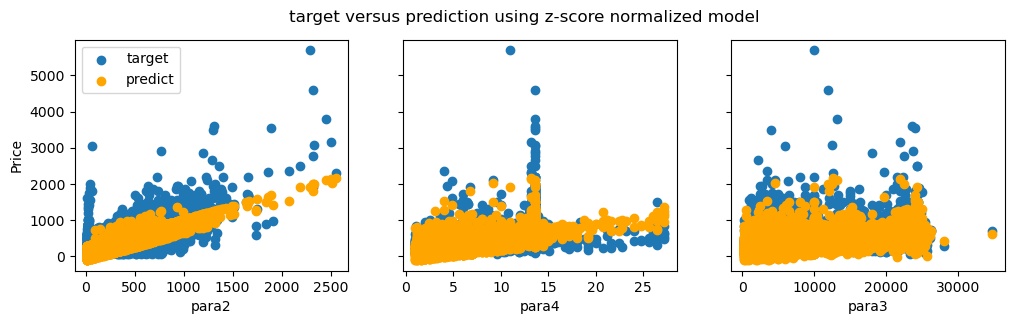

In [24]:
X_features = ['para2', 'para4', 'para3']

# Plot predictions and targets versus original features    
fig,ax=plt.subplots(1,3,figsize=(12, 3),sharey=True)

for i in range(len(ax)):
    ax[i].scatter(X_train.iloc[:,i], y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train.iloc[:,i], y_pred_sgd, color='orange', label = 'predict')
ax[0].set_ylabel("Price"); 
ax[0].legend();
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

## 3 - Run OLS (sklearn OR statsmodels) <a name="3"></a>

I also estimate the linear regression using the ordinary least squares (OLS) method based on the normal equations. 

I implement it using the 'LinearRegression' function in the 'sklearn' package and the 'OLS' function in the 'statsmodels' package. 

As expected, the estimation results obtained from both packages are identical. 

### (sklearn package)

In [25]:
# Train the model
lm = LinearRegression()
lm.fit(X_norm,y_train)

# Check the model outputs
print(lm.intercept_)
print(lm.coef_)

# Model prediction
predictions = lm.predict(X_norm)
predictions[:4]

433.2476283912303
[149.49930432 138.7987328    1.59551669]


array([437.79723462, 381.577339  , -24.99250778,  79.90113916])

In [26]:
# Evaluate the model performance
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, predictions)))

RMSE: 183.61229855726188


### (statsmodel package)

In [27]:
# OR run ols in statsmodel
rhs = sm.add_constant(X_norm)
model = sm.OLS(y_train, rhs)
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     1770.
Date:                Mon, 10 Jul 2023   Prob (F-statistic):               0.00
Time:                        20:59:08   Log-Likelihood:                -66245.
No. Observations:                9989   AIC:                         1.325e+05
Df Residuals:                    9985   BIC:                         1.325e+05
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        433.2476      1.840    235.495      0.0

## 4 - Compare Models <a name="4"></a>

Here are some observations when comparing the estimates results from both the gradient descent algorithm and ordinary least square approach.

The regression estimates obtained from both methods are quite similar, indicating that the gradient descent algorithm works properly with the chosen learning rate. So are the model predictions. 

However, neither model is able to accurately predict the true values, with a large squared root mean square error (RSME) of 184. It suggests that there is considerable room for improvement in the model's predictive performance. 

## 5 - Explore the role of feature scaling <a name="5"></a>

The previous results shown above used the scaled data. Here I present the prediction performance using the unscaled raw data.

Two important observations from this exercise are as follows:

1. <ins>Convergence requires more iterations</ins>: Compared to the scaled data, the unscaled data requires a significantly larger number of iterations to reach convergence. Specifically, the scaled data achieves sensible results after 15 iterations, whereas the unscaled data takes around 120 iterations.

2. <ins>Poorer prediction performance indicated by RMSE after 1000 iterations </ins>: The root mean square error (RMSE) provides a measure of prediction accuracy. The model using scaled data yields an RMSE of approximately 184, while the model using unscaled data produces a considerably higher RMSE of approximately 1.3e+16. This suggests that the model's prediction performance is much poorer when feature scaling is not applied.

In [28]:
sgdr_uns = SGDRegressor(alpha=0.0001, max_iter=1000, random_state=42)
sgdr_uns.fit(X_train, y_train)

SGDRegressor(random_state=42)

In [29]:
b_train_uns = sgdr_uns.intercept_
w_train_uns = sgdr_uns.coef_
print(f"Model intercept equals:{b_train_uns}, slopes equal:{w_train_uns}")

Model intercept equals:[1.23884111e+11], slopes equal:[-2.82581743e+12  1.06227286e+12  1.11372933e+12]


In [30]:
y_pred_sgd_uns = sgdr_uns.predict(X_train)
print(f"Prediction on training set:\n{y_pred_sgd_uns[:4]}" )
print(f"Target values \n{y_train[:4]}")

Prediction on training set:
[1.47465737e+15 2.12301182e+15 2.96516681e+15 1.36800289e+16]
Target values 
0     73.49
1    300.00
2    130.00
3    365.00
Name: price, dtype: float64


In [31]:
print(f"The number of iterations completed:{sgdr_uns.n_iter_}")

The number of iterations completed:120


In [32]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_sgd_uns)))

RMSE: 1.2969610780449968e+16


## Plus - run gradient descent manually <a name="bonus"></a>
For simplicity, I manually run the gradient descent algorithm using only one feature ('para2') with the target outcome still being 'price'. I define three functions following the steps of gradient descent algorithm, which are (1) compute_cost, (2) compute_gradient, (3) (run_)gradient_descent.

I also visualize the impact of the learning rate. Specifically, I compare two learning curves with different learning rates: 0.03 and 0.001. The learning curve presents the cost function values on the y-axis and the number of iterations on the x-axis. 

From the learning curves, I show that the larger learning rate achieves convergence after approximately 80 iterations, while the smaller learning rate remains far from convergence even after 100 iterations.

This demonstrates the importance of selecting an appropriate learning rate for the gradient descent algorithm.

### Manually run gradient descent algorithm

In [33]:
# Keep only one feature (for prediction)
X_train_1 = price_2[['para2']]

In [34]:
# Standardization 
scaler = StandardScaler()
X_norm_1 = scaler.fit_transform(X_train_1)

In [35]:
# Set initial values for w and b
w_init = 0
b_init = 0

In [36]:
# Define a function to compute cost function values
def compute_cost(X, y, w, b):
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        f_wb_i = X[i]*w + b
        cost = cost + (f_wb_i - y[i])**2
    cost = 1/(2*m)*cost
    return cost 

In [37]:
cost = compute_cost(X_norm_1, y_train, w_init, b_init)
print(f'Cost at initial w and b : {cost}')

Cost at initial w and b : [132130.4892035]


In [38]:
# Define a function to compute the gradient for both w and b
def compute_gradient(X, y, w, b):
    """
    Computes the gradient for linear regression 
    Args:
      x (ndarray (m,)): Data, m examples 
      y (ndarray (m,)): target values
      w,b (scalar)    : model parameters  
    Returns
      dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
      dj_db (scalar): The gradient of the cost w.r.t. the parameter b   
    """
    
    m = X.shape[0]
    dj_dw = 0
    dj_db = 0
    
    for i in range(m): 
        f_wb_i = X[i]*w + b
        dj_dw_i = (f_wb_i - y[i])*X[i]
        dj_dw = dj_dw + dj_dw_i
        dj_db_i = (f_wb_i - y[i])
        dj_db = dj_db + dj_db_i
    dj_dw = dj_dw/m
    dj_db = dj_db/m
    return dj_dw, dj_db

In [39]:
gradient = compute_gradient(X_norm_1, y_train, w_init, b_init)
print(f'Gradient at initial w and b : {gradient}')

Gradient at initial w and b : (array([-152.57659241]), array([-433.24762839]))


In [40]:
# Define a function to run the gradient descent and return history of cost function, w, and b
def gradient_descent(X, y, w, b, iters, alpha):
    """
    """
    J_history = []
    p_history = []
    
    for i in range(iters):
        dj_dw, dj_db = compute_gradient(X, y, w, b)

        w = w - alpha*dj_dw
        b = b - alpha*dj_db
        
        if i<100000:
            J_history.append(compute_cost(X,y,w,b))
            p_history.append([w,b])

        if i% math.ceil(iters/10) == 0:
            print(f"Iteration {i}: Cost {J_history[-1]} ",
                  f"dj_dw: {dj_dw}, dj_db: {dj_db}  ",
                  f"w: {w}, b:{b}")
            
#         if i% math.ceil(iters/10) == 0:
#             print(f"Iteration {i:4}: Cost {J_history[-1]:0.2e} ",
#                   f"dj_dw: {dj_dw: 0.3e}, dj_db: {dj_db: 0.3e}  ",
#                   f"w: {w: 0.3e}, b:{b: 0.5e}")
    
    return w, b, J_history, p_history

In [41]:
w_final, b_final, J_hist, p_hist = gradient_descent(X_norm_1, y_train, w_init, b_init, 100, 0.03)
print(f"(w,b) found by gradient descent: ({w_final},{b_final})")

Iteration 0: Cost [125895.93788757]  dj_dw: [-152.57659241], dj_db: [-433.24762839]   w: [4.57729777], b:[12.99742885]
Iteration 10: Cost [80614.32809593]  dj_dw: [-112.51366044], dj_db: [-319.4872541]   w: [43.43834178], b:[123.34499192]
Iteration 20: Cost [55990.44485262]  dj_dw: [-82.97028782], dj_db: [-235.59760941]   w: [72.09541323], b:[204.71794727]
Iteration 30: Cost [42600.11644402]  dj_dw: [-61.18429205], dj_db: [-173.73536141]   w: [93.22782912], b:[264.72432782]
Iteration 40: Cost [35318.53160549]  dj_dw: [-45.11877315], dj_db: [-128.1166472]   w: [108.81138246], b:[308.97448061]
Iteration 50: Cost [31358.84696276]  dj_dw: [-33.27167189], dj_db: [-94.4763067]   w: [120.30307068], b:[341.60561089]
Iteration 60: Cost [29205.59285427]  dj_dw: [-24.5353336], dj_db: [-69.66910798]   w: [128.77731882], b:[365.66859365]
Iteration 70: Cost [28034.66545119]  dj_dw: [-18.09294696], dj_db: [-51.37568113]   w: [135.02643387], b:[383.4132177]
Iteration 80: Cost [27397.92175341]  dj_dw: 

### Visualize the impact of learning rate

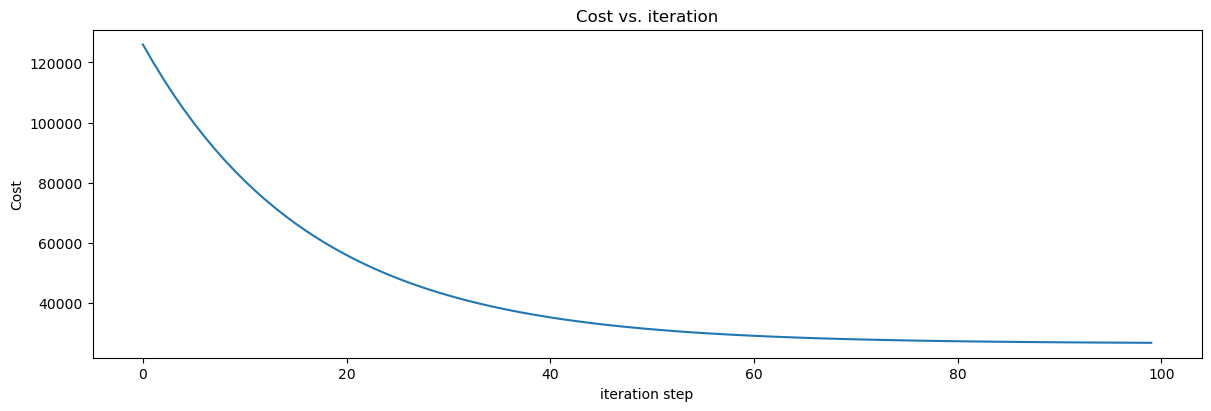

In [42]:
# plot cost versus iteration (\alpha = 0.03)
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12,4))
ax.plot(J_hist[:100])
ax.set_title("Cost vs. iteration")
ax.set_ylabel('Cost')     
ax.set_xlabel('iteration step')  
plt.show()

In [43]:
w_final, b_final, J_hist, p_hist = gradient_descent(X_norm_1, y_train, w_init, b_init, 100, 0.001)
print(f"(w,b) found by gradient descent: ({w_final},{b_final})")

Iteration 0: Cost [131919.61157101]  dj_dw: [-152.57659241], dj_db: [-433.24762839]   w: [0.15257659], b:[0.43324763]
Iteration 10: Cost [129833.88170158]  dj_dw: [-151.05767416], dj_db: [-428.93459635]   w: [1.66997593], b:[4.74196664]
Iteration 20: Cost [127789.47250853]  dj_dw: [-149.55387692], dj_db: [-424.66450106]   w: [3.17226937], b:[9.00779183]
Iteration 30: Cost [125785.56538234]  dj_dw: [-148.06505016], dj_db: [-420.43691508]   w: [4.65960731], b:[13.23115022]
Iteration 40: Cost [123821.3579311]  dj_dw: [-146.59104485], dj_db: [-416.25141523]   w: [6.13213861], b:[17.41246458]
Iteration 50: Cost [121896.06365918]  dj_dw: [-145.13171343], dj_db: [-412.10758253]   w: [7.59001069], b:[21.55215345]
Iteration 60: Cost [120008.91165233]  dj_dw: [-143.68690984], dj_db: [-408.00500218]   w: [9.03336948], b:[25.65063122]
Iteration 70: Cost [118159.14626897]  dj_dw: [-142.25648944], dj_db: [-403.94326351]   w: [10.46235946], b:[29.70830815]
Iteration 80: Cost [116346.02683765]  dj_dw:

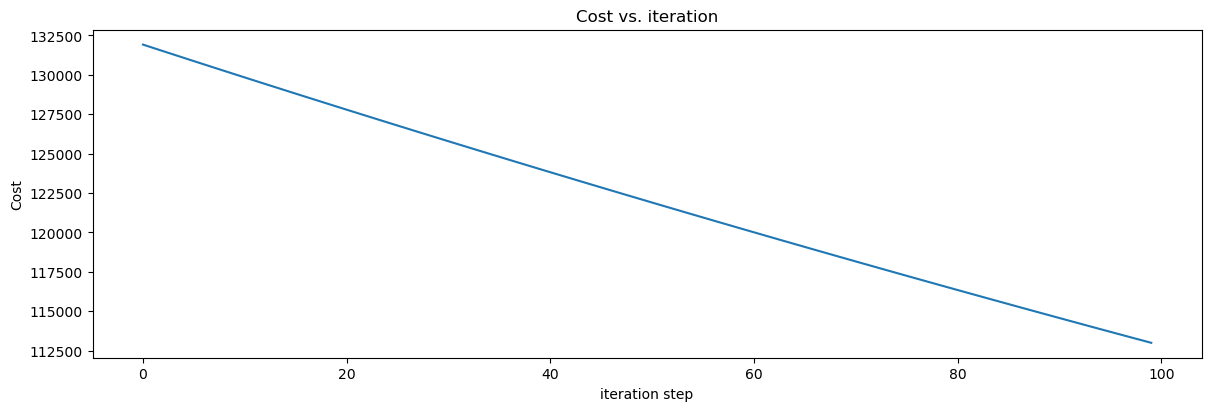

In [44]:
# plot cost versus iteration (\alpha = 0.001)
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12,4))
ax.plot(J_hist[:100])
ax.set_title("Cost vs. iteration")
ax.set_ylabel('Cost')     
ax.set_xlabel('iteration step')  
plt.show()

## Conclusion

In this project, I train the linear regression model using both the gradient descent algorithm and the ordinary least squares (OLS) method, and obtain similar results from both approaches.

I demonstrate how to implement the gradient descent algorithm using the sklearn package as well as a manual implementation.

Furthermore, I highlight the significance of feature scaling and the selection of an appropriate learning rate for the gradient descent algorithm. These factors can impact the convergence rate of the algorithm as well as the prediction performance.